# Random forest regressor analysis

## Introduction

This notebook guides through the analysis of an existing random forest regressor. The performance evaluation is based on the R^2 score from sklearn. The correlation of measured and predicted expression values is plotted. The feature importance from the random forest regression represent the contributions of each nucleotide-position to the prediction. They are extracted and visualized with a Logo-plot.

## System initiation

Loading all necessary libraries.

In [1]:
import time
import os
import pandas as pd
import numpy as np
import logomaker as lm
import matplotlib.pyplot as plt
import joblib
import pickle
from math import sqrt
from ExpressionExpert_Functions import Data_Src_Load, split_train_test, list_onehot, Insert_row_, my_CrossValScore
from sklearn.model_selection import cross_val_score, GroupShuffleSplit
from sklearn.metrics import r2_score, mean_squared_error, make_scorer
%matplotlib inline
my_r2_score = make_scorer(r2_score)

### Variable setting

We load the naming conventions from 'config.txt'

In [2]:
Name_Dict = dict()
with open('config_EcolPtai.txt') as Conf:
    myline = Conf.read().splitlines()
    for line in myline:
        if not line.startswith('#'):
            (key, val) = line.split(':', 1)
            Name_Dict[str(key.strip())] = val.strip()
        

Data_File = Name_Dict['Data_File']
# extract the filename for naming of newly generated files
File_Base = Name_Dict['File_Base']
# the generated files will be stored in a subfolder with custom name
Data_Folder = Name_Dict['Data_Folder']
# column name of expression values
Y_Col_Name = eval(Name_Dict['Y_Col_Name'])
# figure file type
Fig_Type = Name_Dict['Figure_Type']

## Data loading

General information on the data source csv-file is stored in the 'config.txt' file generated in the '0-Workflow' notebook. The sequence and expression data is stored in a csv file with an identifier in column 'ID' (not used for anything), the DNA-sequence in column 'Sequence', and the expression strength in column 'promoter activity'. While loading, the sequence is converted to a label encrypted sequence, ['A','C','G','T'] replaced by [0,1,2,3], and a one-hot encoding.

In [3]:
SeqDat = Data_Src_Load(Name_Dict)
SeqDat.head(3)

,Strain ID Ecol,Strain ID Ptai,Sequence,Ecol Promoter Activity,Ptai Promoter Activity,Sequence_label-encrypted,Sequence_letter-encrypted
0,SN_rep3 20180122,SynPro35_1,"[[0, 0, 0, 1], [0, 0, 0, 1], [0, 0, 0, 1], [1,...",0.043,0.014,"[3, 3, 3, 0, 3, 3, 3, 2, 0, 1, 0, 3, 2, 1, 2, ...",TTTATTTGACATGCGTGATGTTTAGAATTATAATTTGGGG
1,SN_rep3 20180123,SynPro35_2,"[[0, 0, 0, 1], [0, 0, 0, 1], [0, 0, 0, 1], [1,...",0.033,0.015,"[3, 3, 3, 0, 3, 3, 3, 2, 0, 1, 0, 3, 2, 1, 2, ...",TTTATTTGACATGCGTGATGTTTAGAATTATAATTTGGGG
2,SN_rep3 20180124,SynPro35_3,"[[0, 0, 0, 1], [0, 0, 0, 1], [0, 0, 0, 1], [1,...",0.036,0.018,"[3, 3, 3, 0, 3, 3, 3, 2, 0, 1, 0, 3, 2, 1, 2, ...",TTTATTTGACATGCGTGATGTTTAGAATTATAATTTGGGG


## Data manipulation

For the machine learning the data is first separated into training and test sets. The training set is used to generate a standard scaler for expression standardization to zero mean and unit variance. On each position the entropy is calculated to assess how much nucleotide diversity has been sampled on each position. If at any position the entropy is zero, i.e. only one nucleotide is present in all samples, this position is removed because it is non-informative for further analysis (Position entropy analysis). 

### Loading train and test set used for training

In [4]:
TrainTest_File = os.path.join(Data_Folder, '{}_{}_TrainTest-Data.pkl'.format(Name_Dict['RFR_Date'], File_Base))
TrainTest_Data = pickle.load(open(TrainTest_File,'rb'))
SeqTrain, SeqTest = TrainTest_Data['Train'], TrainTest_Data['Test']

## Regressor analysis

In [5]:
# Random Forest Regressor file identifier for date
RFR_Date = Name_Dict['RFR_Date']

# Number of independent promoter library measurements
Measure_Numb = int(Name_Dict['Library_Expression'])
RFR_Best = dict()
Feature_Importance = dict()
Expr_Scaler = dict()
Y_train = np.empty((SeqTrain.shape[0], Measure_Numb))
Y_train_pred_ori = np.empty((SeqTrain.shape[0], Measure_Numb))
Y_test = np.empty((SeqTest.shape[0], Measure_Numb))
Y_test_pred_ori = np.empty((SeqTest.shape[0], Measure_Numb))
scores = np.empty((10, Measure_Numb))

r2_train = np.empty(Measure_Numb)
r2_test = np.empty(Measure_Numb)
rmse_train = np.empty(Measure_Numb)
rmse_test = np.empty(Measure_Numb)
print('Loading regressor')
for Meas_Idx in range(Measure_Numb): 
#     [RFR_Path, RFR_File] = os.path.split(RFR_File)
#     [RFR_Date, RFR_ID, RFR_Proc, RFR_Task] = RFR_File.split('_')
    ML_Regressor_ID = Name_Dict['RFR_ML_File']
    RFR_File = os.path.join(Data_Folder, '{}_{}_{}_{}.pkl'.format(RFR_Date, File_Base, Y_Col_Name[Meas_Idx].replace(' ','-'), ML_Regressor_ID))
    ML_Param_ID = Name_Dict['RFR_Params_File']
    Parameter_File = os.path.join(Data_Folder, '{}_{}_{}_{}.pkl'.format(RFR_Date, File_Base, Y_Col_Name[Meas_Idx].replace(' ','-'), ML_Param_ID))
    
    try:
        RFR_DictName = '{}_RFR'.format(Y_Col_Name[Meas_Idx])
        RFR_Best[RFR_DictName] = joblib.load(RFR_File)
        FI_DictName = '{}_FI'.format(Y_Col_Name[Meas_Idx])
        Feature_Importance[FI_DictName] = np.array(RFR_Best[RFR_DictName].feature_importances_).reshape(-1,4)
        # extracting standard scaler from existing random forest regressor
        # I assume the parameters have been generated in the same run as the regressor itself and is located in the same directory following the default naming scheme
        RFR_Parameter = pickle.load(open(Parameter_File,'rb'))
        # The standard scaler default name is the name of the expression measurement column with suffix: '_Scaler'
        Scaler_DictName = '{}_Scaler'.format(Y_Col_Name[Meas_Idx])
        Expr_Scaler[Scaler_DictName] = RFR_Parameter[Scaler_DictName]
        Positions_removed = RFR_Parameter['Positions_removed']
    except FileNotFoundError:
        print('Target random forest regressor file not found.')
        
    X_tmp = list_onehot(list(np.delete(np.array(list(SeqTrain['Sequence_label-encrypted'])),Positions_removed, axis=1)))
    X_train = np.array(X_tmp).reshape(len(SeqTrain.index),-1)
    # activity prediction of training set with best random forest estimator
    Y_train_pred_ori[:,Meas_Idx] = Expr_Scaler[Scaler_DictName].inverse_transform(RFR_Best[RFR_DictName].predict(X_train))

    # Test set prediction
    # removing sequence positions that were missing in the feature vector for ml
    # getting one-hot encodings from the original train and test data
    X_tmp = list_onehot(list(np.delete(np.array(list(SeqTest['Sequence_label-encrypted'])),Positions_removed, axis=1)))
    X_test = np.array(X_tmp).reshape(len(SeqTest.index),-1)
    # activity prediction of training set with best random forest estimator
    Y_test_pred_ori[:,Meas_Idx] = Expr_Scaler[Scaler_DictName].inverse_transform(RFR_Best[RFR_DictName].predict(X_test))

    # corresponding observations scaled
    Scaler_DictName = '{}_Scaler'.format(Y_Col_Name[Meas_Idx])
    Y_train[:, Meas_Idx] = SeqTrain[Y_Col_Name[Meas_Idx]].values
    Y_test[:, Meas_Idx] = SeqTest[Y_Col_Name[Meas_Idx]].values

    r2_train[Meas_Idx] = r2_score(Y_train[:, Meas_Idx], Y_train_pred_ori[:, Meas_Idx])
    r2_test[Meas_Idx] = r2_score(Y_test[:, Meas_Idx], Y_test_pred_ori[:, Meas_Idx])
    rmse_train[Meas_Idx] = sqrt(mean_squared_error(Y_train[:, Meas_Idx], Y_train_pred_ori[:, Meas_Idx]))
    rmse_test[Meas_Idx] = sqrt(mean_squared_error(Y_test[:, Meas_Idx], Y_test_pred_ori[:, Meas_Idx]))
    
#     # cross-validation scoring
    cv = GroupShuffleSplit(n_splits=10, test_size=.1, random_state=42)
#     Y_train_scaled = np.ravel(Expr_Scaler[Scaler_DictName].transform(SeqTrain[Y_Col_Name[Meas_Idx]].values.reshape(-1, 1)))
    groups = SeqTrain['Sequence_letter-encrypted']
#     scores[Meas_Idx] = cross_val_score(RFR_Best[RFR_DictName], X_train, Y_train_scaled, groups=groups, cv=cv)# , groups=groups, scoring=my_r2_score
    scores[:, Meas_Idx] = my_CrossValScore(X_train, Y_train[:, Meas_Idx], groups, cv, RFR_Best[RFR_DictName], my_r2_score)


print('training set R2 score: {}, RMSE: {}'.format(np.round(r2_train,2), rmse_train))
print('test set R2 score: {}, RMSE: {}'.format(np.round(r2_test,2), rmse_test))


Loading regressor
training set R2 score: [0.95 0.98], RMSE: [0.00513835 0.00164545]
test set R2 score: [0.84 0.73], RMSE: [0.00685281 0.0063747 ]


0.942848417046937
0.7517586435353575


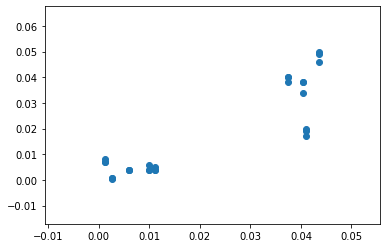

In [155]:
onecv = GroupShuffleSplit(n_splits=1, test_size=.1)
mycv = list(onecv.split(X_train, Y_train, groups))
onetrain = mycv[0][0]
onetest = mycv[0][1]
ML_fun = RFR_Best['Ecol Promoter Activity_RFR']
ML_fun.fit(X_train[onetrain], Y_train[onetrain,0])
print(my_r2_score(ML_fun, X_train[onetrain], Y_train[onetrain,0]))
print(my_r2_score(ML_fun, X_train[onetest], Y_train[onetest,0]))
plt.scatter(ML_fun.predict(X_train[onetest]),Y_train[onetest,0])
plt.show()

In [156]:
from ExpressionExpert_Functions import my_CrossValScore
cv.n_splits = 10
myscores = my_CrossValScore(X_train, Y_train[:,0], groups, cv, ML_fun, my_r2_score)

In [157]:
myscores

[0.5957505591512899,
 0.5356310464527079,
 0.6051417705475026,
 0.6062507421498768,
 0.5954780394176065,
 0.6238772112078848,
 0.6116475525287896,
 0.42694462205367845,
 0.5249898374380755,
 0.44292376580518844]

In [ ]:
#  Y_train_scaled = np.ravel(Expr_Scaler[Scaler_DictName].transform(SeqTrain[Y_Col_Name[1]].values.reshape(-1, 1)))
myscores = list()
for idx in range(cv.n_splits):
    mytrain = list(cv.split(X_train, Y_train, groups))[idx][0]
    mytest = list(cv.split(X_train, Y_train, groups))[idx][1]
    X_sub = X_train[mytrain]
#     Y_sub_exp = Expr_Scaler[Scaler_DictName].transform(Y_train[mytrain])
    RFR_Best[RFR_DictName].fit(X_sub, Y_train[mytrain,1]) #sub_exp[:,1]
    print(Y_train[mytrain,1])
    X_sub_test = X_train[mytest]
#     Y_sub_exp_test = Expr_Scaler[Scaler_DictName].transform(Y_train[mytest])
#     Y_sub_pre = RFR_Best[RFR_DictName].predict(X_sub_test)
    myscores.append(my_r2_score(RFR_Best[RFR_DictName], X_sub_test, Y_train[mytest,1]))

Y_train_scaled = np.ravel(Expr_Scaler[Scaler_DictName].transform(SeqTrain[Y_Col_Name[Meas_Idx]].values.reshape(-1, 1)))
Y_all_sca = Expr_Scaler[Scaler_DictName].transform(Y_train)
# Y_train_scaled
score = cross_val_score(RFR_Best[RFR_DictName], X_train, Y_all_sca, groups, cv=cv, scoring=my_r2_score)
print('crossval: ', score.mean())
print('manual: ', np.array(myscores).mean())

In [ ]:
from sklearn import preprocessing
from sklearn.pipeline import make_pipeline

ML_pipe = make_pipeline(preprocessing.StandardScaler(), RFR_Best['Ptai Promoter Activity_RFR'])
cross_val_score()

## Performance visualization
### Calculation of model predictions

Plot of predicted to measured expression strength for training and test data sets and R$^2$ correlation coefficient.

In [ ]:
# Number of independent promoter library measurements
Measure_Numb = int(Name_Dict['Library_Expression'])
Expr_Unit = Name_Dict['Expression_Unit']

for Meas_Idx in range(Measure_Numb): 
#     fig, axs = plt.subplots(nrows=1, ncols=1)
    plt.scatter(Y_train[:, Meas_Idx], Y_train_pred_ori[:, Meas_Idx], marker='+')
    plt.scatter(Y_test[:, Meas_Idx], Y_test_pred_ori[:, Meas_Idx], marker='o', c='r')
    plt.title(Y_Col_Name[Meas_Idx])
    plt.xlabel('measured {}'.format(Expr_Unit))
    plt.ylabel('predicted {}'.format(Expr_Unit))
    plt.legend(['Training set, R$^2$={:.2f}'.format(r2_train[Meas_Idx]),'Test set, R$^2$={:.2f}'.format(r2_test[Meas_Idx])], loc='upper left')

    # saving the figure
    Fig_ID = Name_Dict['CorrPlot_File']
    CorrPlot_File = os.path.join(Data_Folder, '{}_{}_{}_{}.{}'.format(time.strftime('%Y%m%d'), File_Base, Fig_ID, Y_Col_Name[Meas_Idx].replace(' ','-'), Fig_Type))
    plt.savefig(CorrPlot_File, bbox_inches='tight', format=Fig_Type)

    plt.show()

### Sequence logo for feature importance

The feature importance of the random forest regressor, i.e. the y-axis in the Logo-plot, is normalized to sum over all nucleotide-positions to one.

The logos are generated with [Logomaker](https://logomaker.readthedocs.io/en/latest/).

In [ ]:
# Number of independent promoter library measurements
Measure_Numb = int(Name_Dict['Library_Expression'])
Expr_Unit = Name_Dict['Expression_Unit']

for Meas_Idx in range(Measure_Numb): 
    MeasName = '{}_FI'.format(Y_Col_Name[Meas_Idx])
    PWM_tmp = pd.DataFrame(Feature_Importance[MeasName], columns=['A','C','G','T'])
    PWM_best = Insert_row_(Positions_removed, PWM_tmp, np.zeros([len(Positions_removed),4]))
    nn_logo = lm.Logo(PWM_best)
    nn_logo.ax.set_xlabel('Position')
    nn_logo.ax.set_ylabel(r'$\frac{Importance_i}{\sum Importance}$')
    nn_logo.ax.set_title(Y_Col_Name[Meas_Idx])
    
    # saving the figure
    Fig_ID = Name_Dict['LogoPlot_File']
    LogoPlot_File = os.path.join(Data_Folder, '{}_{}_{}_{}.{}'.format(time.strftime('%Y%m%d'), File_Base, Fig_ID, Y_Col_Name[Meas_Idx].replace(' ','-'), Fig_Type))
#     plt.savefig(LogoPlot_File, bbox_inches='tight', format=Fig_Type)

    plt.show()
